<a href="https://colab.research.google.com/github/NavinAnto-03/AI-Projects/blob/main/Ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving NVIDIA_STOCK.csv to NVIDIA_STOCK (3).csv


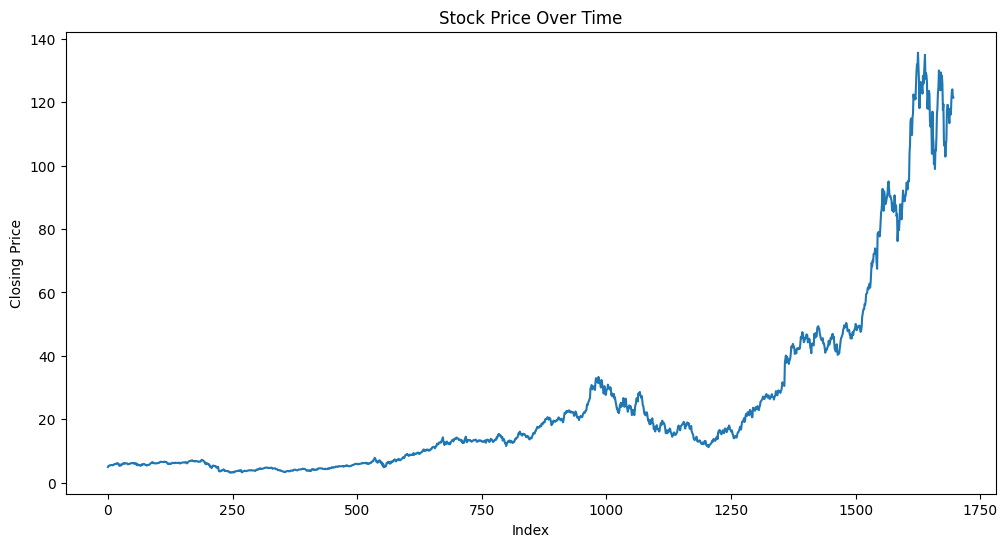

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 - 6s - 149ms/step - loss: 0.0014 - val_loss: 5.1656e-04
Epoch 2/50
38/38 - 1s - 33ms/step - loss: 2.0813e-04 - val_loss: 6.0330e-04
Epoch 3/50
38/38 - 1s - 33ms/step - loss: 1.9821e-04 - val_loss: 3.2889e-04
Epoch 4/50
38/38 - 1s - 33ms/step - loss: 1.7924e-04 - val_loss: 4.1771e-04
Epoch 5/50
38/38 - 1s - 33ms/step - loss: 1.5226e-04 - val_loss: 2.4827e-04
Epoch 6/50
38/38 - 1s - 32ms/step - loss: 1.6015e-04 - val_loss: 3.2203e-04
Epoch 7/50
38/38 - 1s - 38ms/step - loss: 1.4028e-04 - val_loss: 2.9764e-04
Epoch 8/50
38/38 - 2s - 55ms/step - loss: 1.4148e-04 - val_loss: 1.7713e-04
Epoch 9/50
38/38 - 1s - 36ms/step - loss: 1.4291e-04 - val_loss: 2.5485e-04
Epoch 10/50
38/38 - 1s - 33ms/step - loss: 1.4316e-04 - val_loss: 3.7386e-04
Epoch 11/50
38/38 - 1s - 33ms/step - loss: 1.0826e-04 - val_loss: 2.5406e-04
Epoch 12/50
38/38 - 1s - 34ms/step - loss: 1.2201e-04 - val_loss: 2.3513e-04
Epoch 13/50
38/38 - 2s - 65ms/step - loss: 1.0561e-04 - val_loss: 6.0823e-04
Epoch 14/50
38/38 - 1s

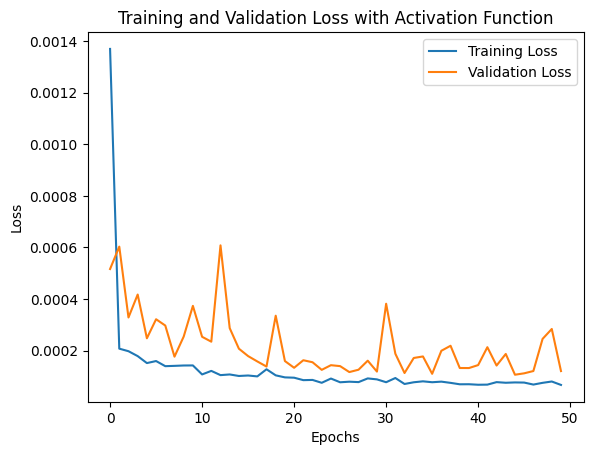

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


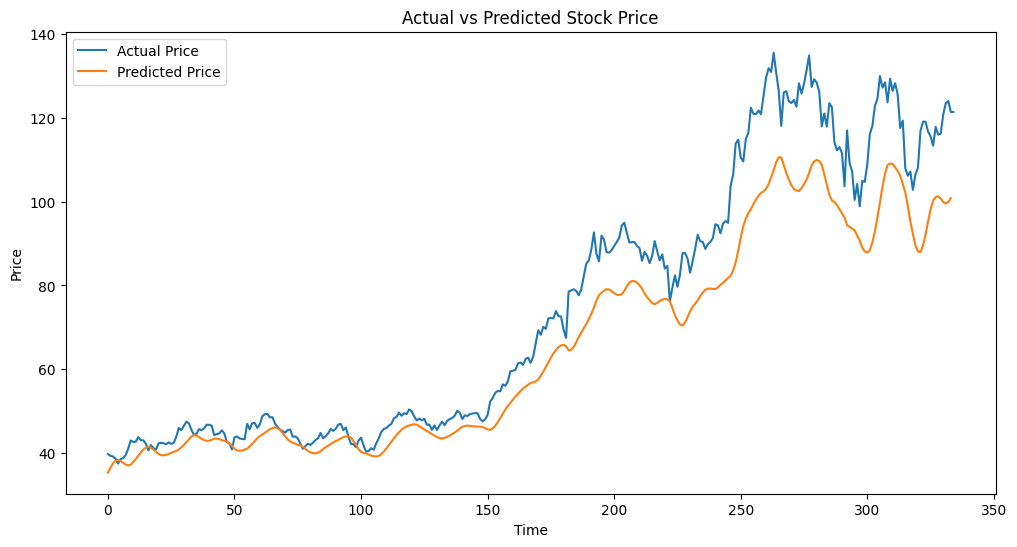

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted next day's stock price: 102.3005599975586


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from google.colab import files

uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(file_name)

if 'Close' not in df.columns:
    close_col = [c for c in df.columns if 'Close' in c or 'close' in c]
    if close_col:
        df.rename(columns={close_col[0]: 'Close'}, inplace=True)
    else:
        df.rename(columns={df.columns[1]: 'Close'}, inplace=True)

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])

plt.figure(figsize=(12,6))
plt.plot(df['Close'].values)
plt.title('Stock Price Over Time')
plt.xlabel('Index')
plt.ylabel('Closing Price')
plt.show()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

X, y = create_dataset(scaled_data)
X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Activation('relu'),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Activation('relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=2)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss with Activation Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(predictions)

plt.figure(figsize=(12,6))
plt.plot(df['Close'].values[train_size+30:], label='Actual Price')
plt.plot(predictions_rescaled.flatten(), label='Predicted Price')
plt.title('Actual vs Predicted Stock Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

last_30_days = df['Close'].values[-30:]
last_30_scaled = scaler.transform(last_30_days.reshape(-1,1))
last_30_scaled = last_30_scaled.reshape(1,30,1)
next_day_pred = model.predict(last_30_scaled)
print(f"Predicted next day's stock price: {scaler.inverse_transform(next_day_pred)[0][0]}")
